<a href="https://colab.research.google.com/github/Melania-77/health_economics_challenge/blob/main/Decidir_variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cargar archivo


In [9]:
from google.colab import files
import pandas as pd

# Subir archivo desde tu PC
uploaded = files.upload()



Saving dataset_desafio.csv to dataset_desafio (2).csv


In [10]:
# Ver el nombre del archivo subido
for filename in uploaded.keys():
    print("Archivo subido:", filename)

# Cargarlo en un DataFrame
df = pd.read_csv(filename)

# Ver primeras filas
print(df.head())

# Ver dimensiones (filas, columnas)
print(df.shape)

# Ver las columnas disponibles en el DataFrame
print(df.columns.tolist())

# Ver tipos de datos
print(df.info())



Archivo subido: dataset_desafio (2).csv
    Country Name Country Code  year  AG.CON.FERT.ZS  AG.LND.AGRI.K2  \
0  Guinea-Bissau          GNB  2000        8.000000         6631.20   
1  Guinea-Bissau          GNB  2001        8.000000         6715.65   
2  Guinea-Bissau          GNB  2002        9.654250         6800.10   
3  Guinea-Bissau          GNB  2003       10.958519         6884.55   
4  Guinea-Bissau          GNB  2004       10.183571         6969.00   

   AG.LND.AGRI.ZS  AG.LND.ARBL.HA  AG.LND.ARBL.HA.PC  AG.LND.ARBL.ZS  \
0       23.581792        300000.0           0.242966       10.668563   
1       23.882112        300000.0           0.237855       10.668563   
2       24.182432        280000.0           0.217171        9.957326   
3       24.482752        270000.0           0.204731        9.601707   
4       24.783073        280000.0           0.207475        9.957326   

   AG.LND.CREL.HA  ...  TX.VAL.MRCH.RS.ZS  TX.VAL.MRCH.WL.CD  \
0          162150  ...              

Preparar datos para Random Forest
Definir X (predictoras) e y (target)


In [11]:
# Target: gasto de bolsillo en salud per cápita PPP
y = df["hf3_ppp_pc"]

# Predictoras: todas las demás columnas menos el target
X = df.drop(columns=["hf3_ppp_pc", "Country Name", "Country Code"])
# removemos también 'Country Name' y 'Country Code' porque son identificadores, no predictoras

Entrenar Random Forest

In [12]:
from sklearn.preprocessing import LabelEncoder

# Copia del dataframe
df_model = df.copy()

# Eliminar columnas que no sirven como predictoras
df_model = df_model.drop(columns=["Country Name", "Country Code"])

# Codificar variables categóricas
for col in ["region", "income"]:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])

# Definir X e y
X = df_model.drop(columns=["hf3_ppp_pc"])
y = df_model["hf3_ppp_pc"]

# Dividir datos
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)

Ver importancia de variables


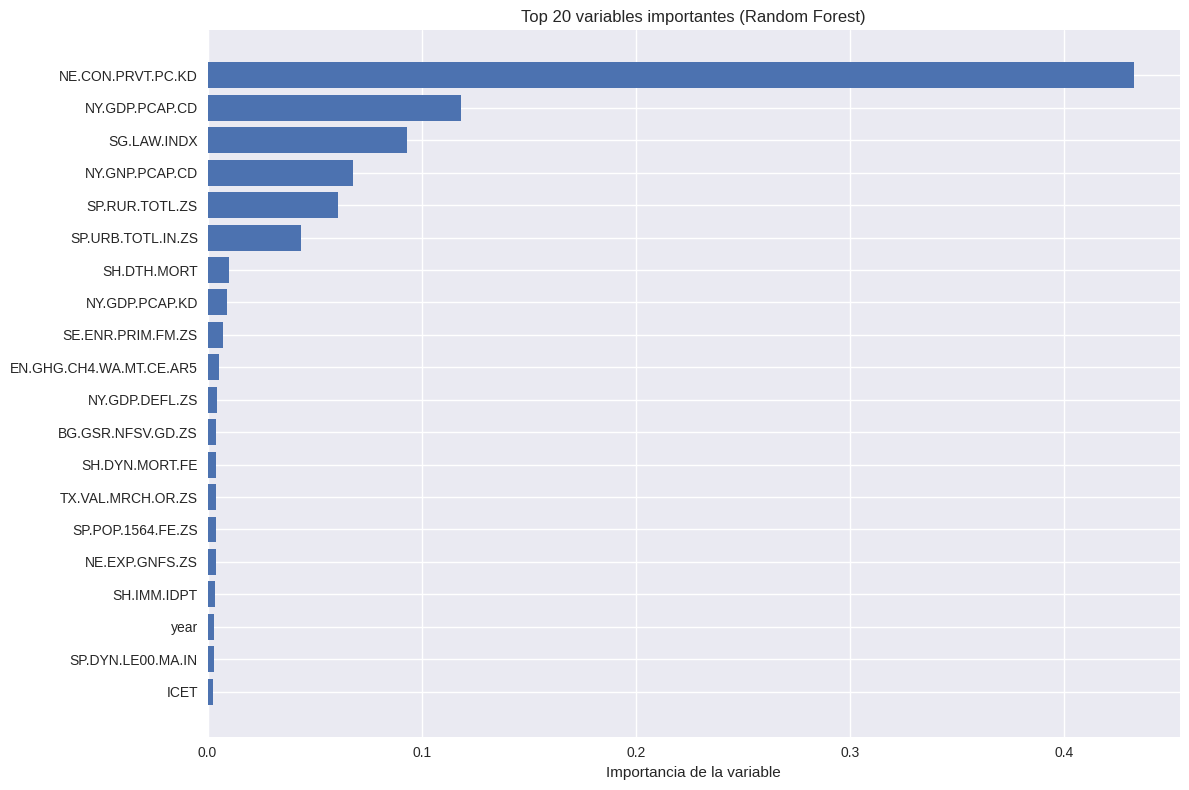

In [81]:
import matplotlib.pyplot as plt
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 20
plt.figure(figsize=(12,8)) # Increased figure height for horizontal bars
plt.barh(range(top_n), importances[indices[:top_n]][::-1]) # Use barh for horizontal bars, reverse order for top at the top
plt.yticks(range(top_n), [X.columns[i] for i in indices[:top_n]][::-1]) # Use yticks for labels and reverse order
plt.xlabel("Importancia de la variable") # Changed x-label for horizontal chart
plt.title("Top 20 variables importantes (Random Forest)")
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()

## Seleccionar variables importantes


Filtrar el DataFrame para incluir solo las variables identificadas como más importantes por el modelo Random Forest (las 20 principales).


Para filtrar los DataFrames, primero se identifican los nombres de las 20 características más importantes en función de las matrices de importancia e índices obtenidos del modelo Random Forest, y luego se usan estos nombres para seleccionar las columnas relevantes de X_train y X_test para crear X_train_filtered y X_test_filtered.


In [14]:
top_20_features = [X.columns[i] for i in indices[:top_n]]

X_train_filtered = X_train[top_20_features]
X_test_filtered = X_test[top_20_features]

print("X_train_filtered shape:", X_train_filtered.shape)
print("X_test_filtered shape:", X_test_filtered.shape)
print("Top 20 features:\n", top_20_features)

X_train_filtered shape: (403, 20)
X_test_filtered shape: (101, 20)
Top 20 features:
 ['NE.CON.PRVT.PC.KD', 'NY.GDP.PCAP.CD', 'SG.LAW.INDX', 'NY.GNP.PCAP.CD', 'SP.RUR.TOTL.ZS', 'SP.URB.TOTL.IN.ZS', 'NY.GDP.PCAP.KD', 'SH.DTH.MORT', 'SE.ENR.PRIM.FM.ZS', 'EN.GHG.CH4.WA.MT.CE.AR5', 'NY.GDP.DEFL.ZS', 'NE.EXP.GNFS.ZS', 'SH.DYN.MORT.FE', 'BG.GSR.NFSV.GD.ZS', 'SP.POP.1564.FE.ZS', 'TX.VAL.MRCH.OR.ZS', 'SH.IMM.IDPT', 'SE.TER.ENRR', 'IT.CEL.SETS.P2', 'year']


## Preparar datos para clustering

Preprocesar los datos seleccionados, incluyendo la imputación de valores faltantes si los hubiera y el escalado de las variables para asegurar que todas contribuyan equitativamente al clustering.


La subtarea requiere el preprocesamiento de los datos seleccionados. Primero, se imputan los valores faltantes utilizando SimpleImputer con una estrategia de "mediana", ajustando los datos de entrenamiento y transformando los conjuntos de entrenamiento y de prueba. Después, se escalan las características utilizando StandardScaler, ajustando los datos de entrenamiento imputados y transformando ambos conjuntos. Esto garantiza un preprocesamiento consistente en todos los conjuntos de datos y los prepara para la agrupación.


In [15]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Imputar valores faltantes
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_filtered), columns=X_train_filtered.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_filtered), columns=X_test_filtered.columns)

# Escalar las variables
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train_imputed.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_test_imputed.columns)

print("X_train_imputed shape:", X_train_imputed.shape)
print("X_test_imputed shape:", X_test_imputed.shape)
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train_imputed shape: (403, 20)
X_test_imputed shape: (101, 20)
X_train_scaled shape: (403, 20)
X_test_scaled shape: (101, 20)


## Determinar número óptimo de clusters (Método del Codo)


Utilizar el método del codo para ayudar a determinar el número óptimo de clusters para el algoritmo K-Means.


Para determinar la cantidad óptima de clústeres utilizando el método del codo, se iterara a través de un rango de números de clústeres, se ajusta un modelo KMeans para cada uno, se registra el WCSS (inercia) y luego se grafican estos valores para identificar el punto de "codo".

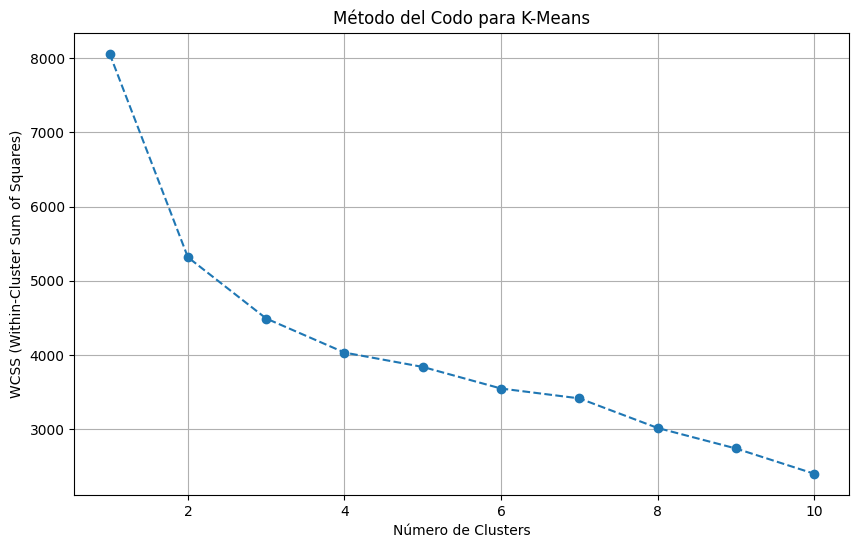

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
# Iterate through a range of possible cluster numbers
for i in range(1, 11): # Checking for 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(X_train_scaled)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Método del Codo para K-Means')
plt.grid(True)
plt.show()

## Aplicar algoritmo K-Means

Aplicar el algoritmo K-Means a los datos preprocesados para agrupar las observaciones en clusters.


Aplicamos el algoritmo K-Means a los datos de entrenamiento preprocesados ​​y escalados (X_train_scaled) para agrupar las observaciones en clústeres. Según el gráfico del método del codo, 4 clústeres parecen ser una opción razonable. Posteriormente, se predecen las etiquetas de los clústeres para los conjuntos de entrenamiento y de prueba.


In [17]:
from sklearn.cluster import KMeans

# Instantiate KMeans with the optimal number of clusters (4 from elbow method)
# n_init='auto' to explicitly handle the initialization method, which is good practice
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')

# Fit the KMeans model to the scaled training data
kmeans.fit(X_train_scaled)

# Predict the cluster labels for both training and test sets
X_train_scaled['cluster_label'] = kmeans.labels_
X_test_scaled['cluster_label'] = kmeans.predict(X_test_scaled)

print("K-Means clustering applied successfully.")
print("First 5 cluster labels for X_train_scaled:\n", X_train_scaled['cluster_label'].head())
print("First 5 cluster labels for X_test_scaled:\n", X_test_scaled['cluster_label'].head())

K-Means clustering applied successfully.
First 5 cluster labels for X_train_scaled:
 0    2
1    1
2    0
3    2
4    2
Name: cluster_label, dtype: int32
First 5 cluster labels for X_test_scaled:
 0    1
1    3
2    3
3    2
4    3
Name: cluster_label, dtype: int32


## Visualizar clusters (PCA)


Reducir la dimensionalidad de los datos usando PCA para poder visualizar los clusters en un gráfico 2D o 3D, mostrando cómo se agrupan las observaciones basadas en las variables importantes. Se incluirá una leyenda para diferenciar los clusters.


Se importan las bibliotecas necesarias y se aplica PCA para reducir la dimensionalidad de los datos de entrenamiento escalados a dos componentes, creando un DataFrame con estos componentes y sus etiquetas de grupo, y luego se produce la visualización de los grupos utilizando un gráfico de dispersión coloreado por grupo.



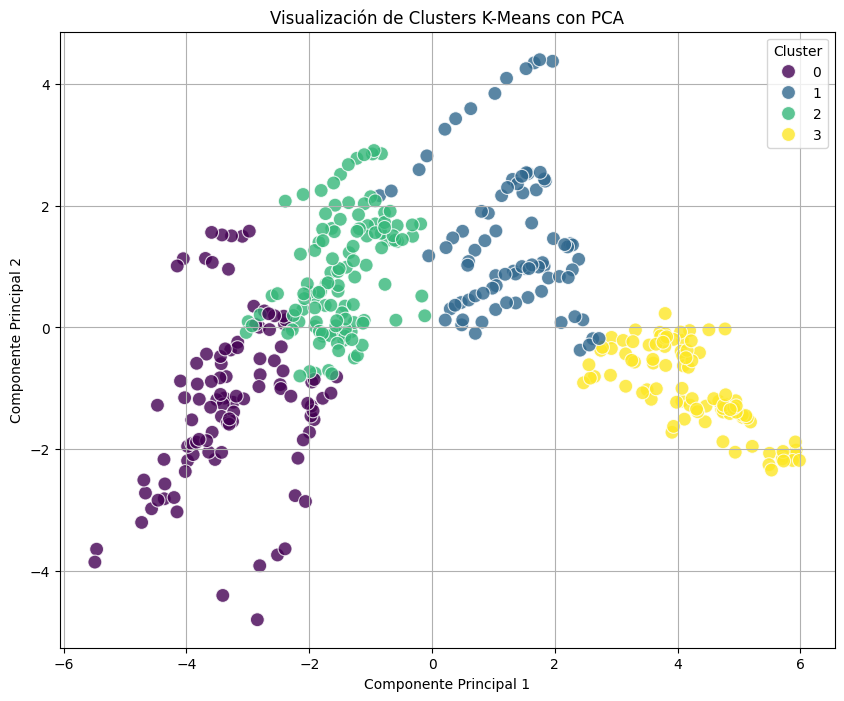

In [18]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Instantiate PCA with 2 components
pca = PCA(n_components=2)

# Apply PCA to X_train_scaled, excluding 'cluster_label'
X_train_pca = pca.fit_transform(X_train_scaled.drop(columns=['cluster_label']))

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=X_train_pca, columns=['PC1', 'PC2'])
pca_df['cluster_label'] = X_train_scaled['cluster_label'].reset_index(drop=True)

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster_label', data=pca_df, palette='viridis', s=100, alpha=0.8)
plt.title('Visualización de Clusters K-Means con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


## Analizar características de los clusters

Examinar las características de cada cluster con respecto a las variables importantes para entender qué define a cada grupo.


Para comprender las características de cada clúster, agrupamos el DataFrame X_train_scaled por la etiqueta del clúster y calculamos la media de todas las características dentro de cada clúster. Esto resaltará las variables más prominentes para cada grupo.



In [19]:
cluster_characteristics = X_train_scaled.groupby('cluster_label').mean()
print("Mean characteristics for each cluster:")
print(cluster_characteristics)

Mean characteristics for each cluster:
               NE.CON.PRVT.PC.KD  NY.GDP.PCAP.CD  SG.LAW.INDX  NY.GNP.PCAP.CD  \
cluster_label                                                                   
0                      -0.652099       -0.675105    -1.150786       -0.667989   
1                      -0.113132       -0.165690     0.427558       -0.182257   
2                      -0.667616       -0.632069    -0.141339       -0.626224   
3                       1.638773        1.664702     1.053699        1.664012   

               SP.RUR.TOTL.ZS  SP.URB.TOTL.IN.ZS  NY.GDP.PCAP.KD  SH.DTH.MORT  \
cluster_label                                                                   
0                    0.883194          -0.883194       -0.696579     0.246913   
1                   -0.913631           0.913631       -0.092611    -0.118437   
2                    0.733553          -0.733553       -0.663451     0.112402   
3                   -1.083824           1.083824        1.664010    -

## Hallazgos del análisis de clustering


El análisis tuvo como objetivo identificar y caracterizar grupos diferenciados dentro de los datos en función de variables importantes. Se determinó que el número óptimo de conglomerados era de 4, y estos conglomerados se formaron y analizaron con éxito para determinar sus características definitorias.

Resultados clave del análisis de datos

Selección de características: El análisis se centró en las 20 características más importantes, incluyendo indicadores como 'NE.CON.PRVT.PC.KD' (Consumo privado, etc.), 'NY.GDP.PCAP.CD' (PIB per cápita), 'SG.LAW.INDX' (Índice de ley y orden) y 'año'.
Preprocesamiento de datos: Los valores faltantes en las características seleccionadas se imputaron utilizando la estrategia de la mediana, y todas las características se escalaron posteriormente utilizando StandardScaler para garantizar una contribución equitativa al proceso de agrupamiento.
Número óptimo de clústeres: el método del codo indicó que 4 era el número óptimo de clústeres para el algoritmo K-Means, ya que este punto marcó una reducción significativa en la tasa de disminución de la suma de cuadrados dentro del clúster (WCSS).
Agrupamiento K-Medias: El algoritmo K-Medias se aplicó con 4 clústeres, asignando correctamente una etiqueta de clúster a cada punto de datos, tanto en el conjunto de entrenamiento como en el de prueba.
Visualización de clústeres: El Análisis de Componentes Principales (ACP) redujo la dimensionalidad de los datos a dos componentes, lo que permitió una visualización 2D que ilustró claramente la separación y agrupación de los cuatro clústeres identificados.

Características de los clústeres:

Clúster 0: Se caracteriza por indicadores económicos generalmente más bajos (p. ej., PIB per cápita), mayor población rural, tasas de mortalidad más altas y un índice de orden público más bajo.

Clúster 1: Presentó indicadores económicos moderados, mayor población urbana, valores notablemente altos de emisiones de metano y una mayor matriculación femenina en primaria, en comparación con el Clúster 0.

Clúster 2: Presentó características similares al Clúster 0, con indicadores económicos más bajos y mayor población rural, pero en general presentó tasas de mortalidad más bajas y un índice de orden público cercano a la media.

Clúster 3: Se destacó con valores medios significativamente más altos para la mayoría de los indicadores económicos, una población urbana muy alta, las tasas de mortalidad más bajas, un alto "Índice de ley y orden" y un alto "Conjunto de teléfonos celulares con Internet por cada 100 personas".

Perspectivas o próximos pasos
Las características distintivas de los cuatro clústeres sugieren diferentes perfiles de desarrollo socioeconómico entre las entidades observadas. El clúster 3 parece representar regiones altamente desarrolladas, mientras que los clústeres 0 y 2 podrían representar regiones menos desarrolladas o en desarrollo con diversos grados de desafíos sociales.
Una investigación más profunda podría incluir el examen de la distribución de países o períodos específicos dentro de cada clúster para comprender el contexto y las implicaciones de estas agrupaciones, lo que podría conducir a recomendaciones de políticas específicas o a un análisis más profundo de los factores que impulsan estas distinciones.

# Árboles de decisión
Se construye, evalúa y visualiza un modelo de Árbol de Decisión (Decision Tree Regressor) utilizando los datos `X_train_imputed`, `X_test_imputed`, `y_train` e `y_test`.

## Preparar datos para Árbol de Decisión

Se utilizan los datos `X_train_imputed`, `X_test_imputed`, `y_train` y `y_test` que ya fueron preprocesados y escalados para entrenar el modelo de Árbol de Decisión. No será necesario un escalado adicional ya que los árboles de decisión no son sensibles a la escala de las características, pero sí es importante tener los valores imputados.


Para confirmar que los conjuntos de datos están listos para entrenar el modelo de árbol de decisión, se imprimen las formas de X_train_imputed, X_test_imputed, y_train y y_test.



In [20]:
print("Shape of X_train_imputed:", X_train_imputed.shape)
print("Shape of X_test_imputed:", X_test_imputed.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train_imputed: (403, 20)
Shape of X_test_imputed: (101, 20)
Shape of y_train: (403,)
Shape of y_test: (101,)


Se confirmó que los datos están listos, entonces se entrena un modelo regresor de árbol de decisión utilizando los conjuntos de datos X_train_imputed e y_train.



In [21]:
from sklearn.tree import DecisionTreeRegressor

# Instantiate the Decision Tree Regressor model
dt_regressor = DecisionTreeRegressor(random_state=42)

# Train the model using the imputed training data
dt_regressor.fit(X_train_imputed, y_train)

print("Decision Tree Regressor model trained successfully.")

Decision Tree Regressor model trained successfully.


 Con el modelo de regresor de árbol de decisión ya entrenado, el siguiente paso es evaluar su rendimiento en el conjunto de prueba. Utilizamos el modelo entrenado para realizar predicciones en X_test_imputed y luego calculamos métricas de regresión comunes como el error absoluto medio (MAE), el error cuadrático medio (MSE) y el R cuadrado (R²) para evaluar la generalización del modelo.

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions on the imputed test set
y_pred = dt_regressor.predict(X_test_imputed)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Mean Absolute Error (MAE): 27.35
Mean Squared Error (MSE): 9757.82
Root Mean Squared Error (RMSE): 98.78
R-squared (R2): 0.85


## Visualizar el Árbol de Decisión

Visualizar el árbol de decisión entrenado para entender su estructura y las reglas de decisión que utiliza. Esto se realizará de manera simplificada para una mejor interpretación.


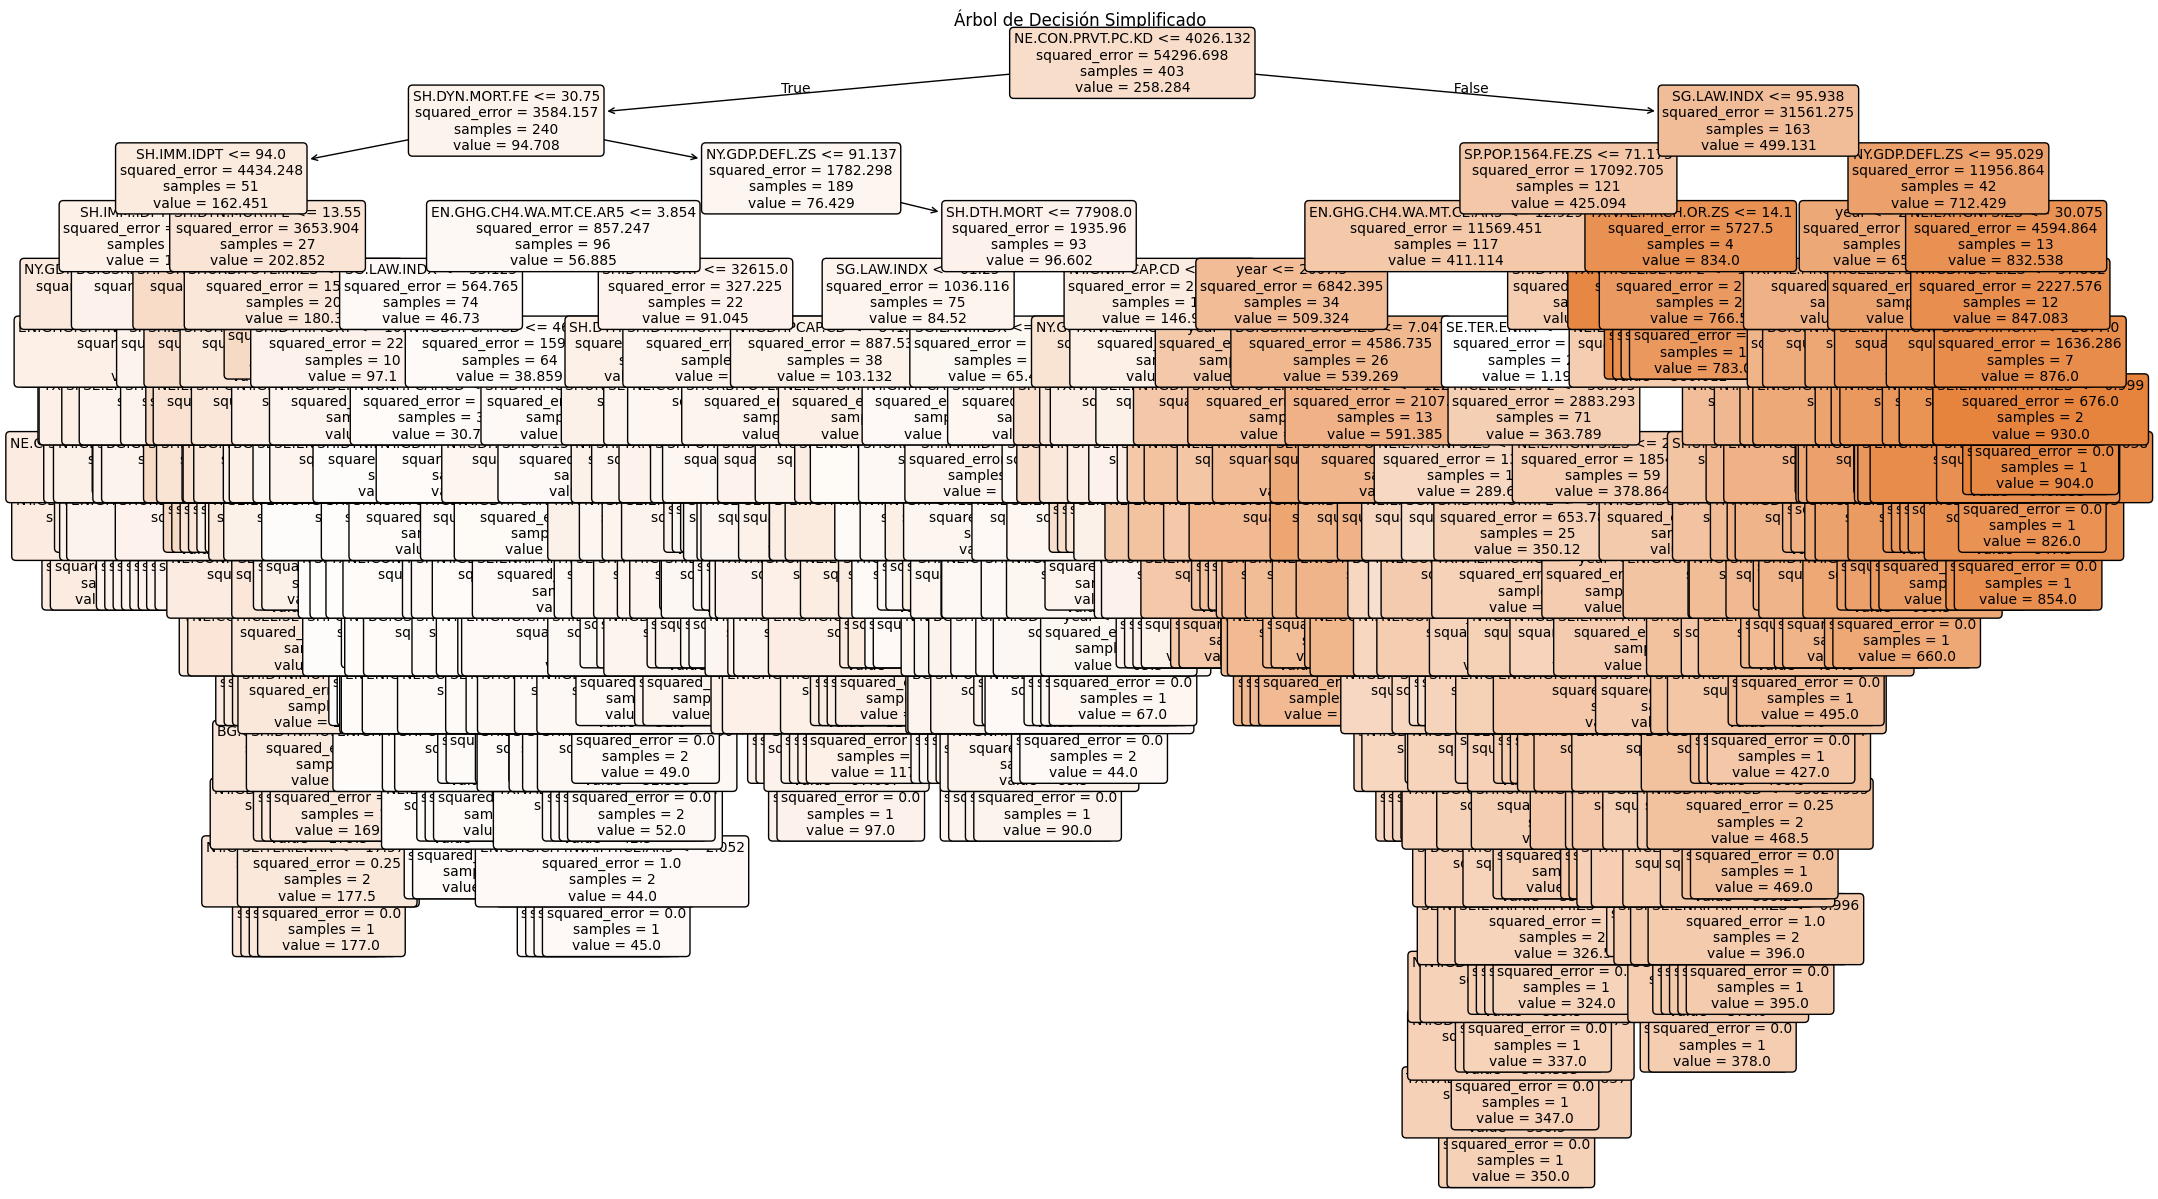

In [23]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 15))
plot_tree(dt_regressor,
          feature_names=X_train_imputed.columns,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Árbol de Decisión Simplificado')
plt.show()

## Entrenar Árbol de Decisión Podado

Re-entrenar un modelo `DecisionTreeRegressor` con el parámetro `min_samples_leaf=5` para podar el árbol y evitar hojas con muy pocas muestras, utilizando `X_train_imputed` y `y_train`.


Se reentrena un regresor de árbol de decisión con un parámetro de poda específico (min_samples_leaf=5). Se instancia el modelo con este parámetro y un estado aleatorio, y luego se lo entrena utilizando los conjuntos de datos X_train_imputed e y_train.



In [24]:
from sklearn.tree import DecisionTreeRegressor

# Instantiate the Decision Tree Regressor model with pruning parameter
dt_regressor_pruned = DecisionTreeRegressor(min_samples_leaf=5, random_state=42)

# Train the pruned model using the imputed training data
dt_regressor_pruned.fit(X_train_imputed, y_train)

print("Pruned Decision Tree Regressor model trained successfully.")

Pruned Decision Tree Regressor model trained successfully.


Una vez entrenado el modelo regresor de árbol de decisión podado, el siguiente paso es evaluar su rendimiento en el conjunto de prueba. Esto implica realizar predicciones sobre X_test_imputed y calcular métricas de regresión estándar (MAE, MSE, RMSE, R-cuadrado) para evaluar la capacidad de generalización del modelo.


In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions on the imputed test set using the pruned model
y_pred_pruned = dt_regressor_pruned.predict(X_test_imputed)

# Evaluate the pruned model
mae_pruned = mean_absolute_error(y_test, y_pred_pruned)
mse_pruned = mean_squared_error(y_test, y_pred_pruned)
rmse_pruned = np.sqrt(mse_pruned)
r2_pruned = r2_score(y_test, y_pred_pruned)

print(f"Pruned Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_pruned:.2f}")
print(f"Mean Squared Error (MSE): {mse_pruned:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_pruned:.2f}")
print(f"R-squared (R2): {r2_pruned:.2f}")

Pruned Model Evaluation:
Mean Absolute Error (MAE): 36.97
Mean Squared Error (MSE): 6927.77
Root Mean Squared Error (RMSE): 83.23
R-squared (R2): 0.89


Se visualiza el árbol de decisión podado utilizando el modelo dt_regressor_pruned, X_train_imputed.columns para los nombres de las características, confilled=True, rounded=True y fontsize=10, y establezca el título en 'Árbol de Decisión Podado'.

## Visualizar el árbol de Decisión Podado




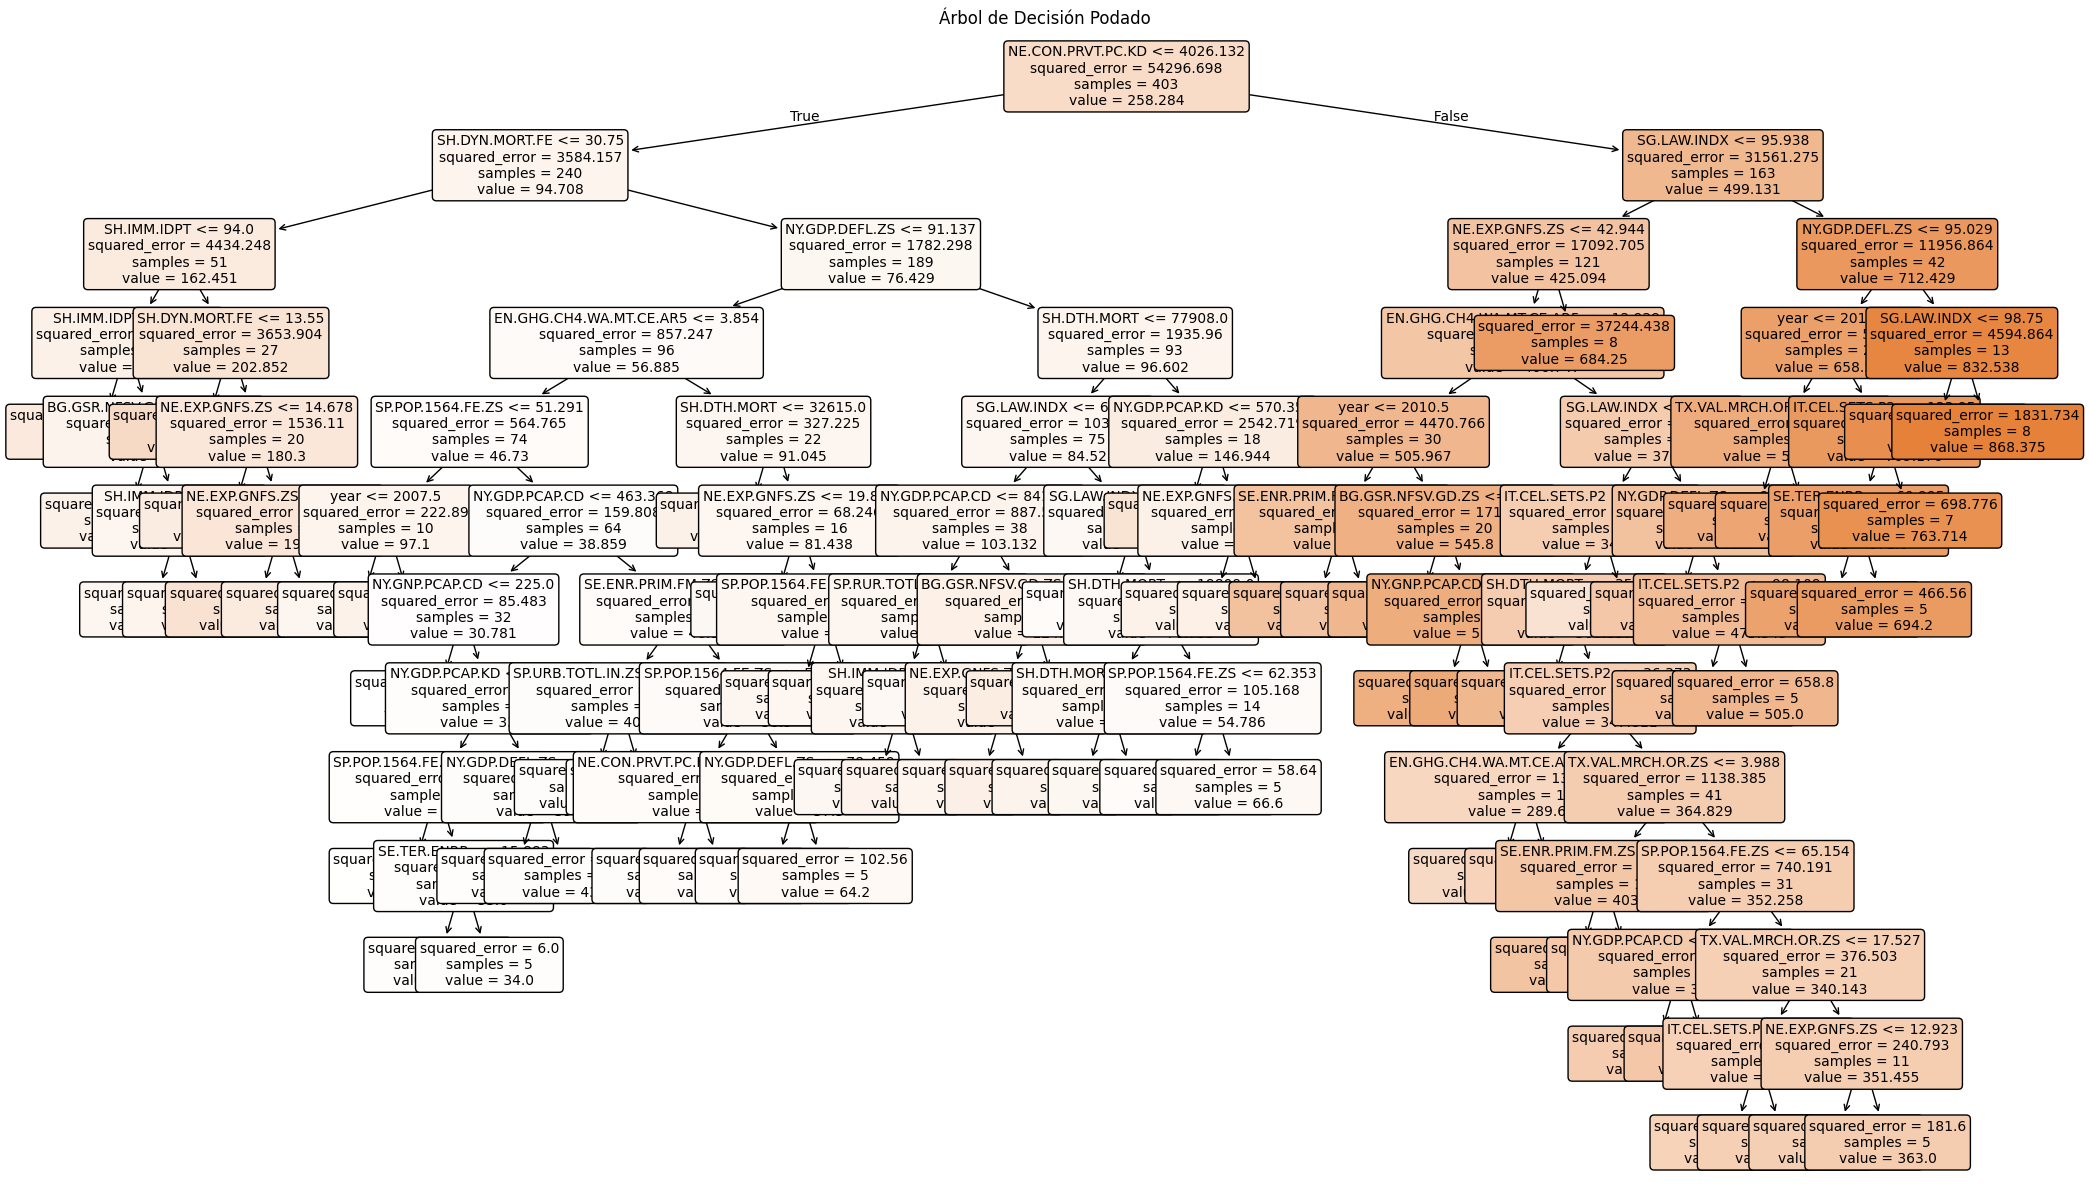

In [26]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 15))
plot_tree(dt_regressor_pruned,
          feature_names=X_train_imputed.columns,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Árbol de Decisión Podado')
plt.show()

Índices a analizar

In [83]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# -------------------------------
# 1. Copia del dataset y limpieza
# -------------------------------
df_model = df.copy()

# Eliminar identificadores no predictivos
df_model = df_model.drop(columns=["Country Name", "Country Code"])

# -------------------------------
# 2. Codificar categóricas
# -------------------------------
for col in ["region", "income"]:
    df_model[col] = LabelEncoder().fit_transform(df_model[col].astype(str))

# -------------------------------
# 3. Convertir columnas residuales tipo object a numéricas
# -------------------------------
for col in df_model.columns:
    if df_model[col].dtype == "object":
        df_model[col] = pd.to_numeric(df_model[col], errors="coerce")

# -------------------------------
# 4. Crear los 7 índices derivados
# -------------------------------

# 1. Índice de capacidad de pago ajustada (ICP)
df_model["ICP"] = np.log(df_model["hf3_ppp_pc"].astype(float) + 1) / (1 + df_model["FP.CPI.TOTL.ZG"].astype(float))

# 2. Índice de presión demográfica en salud (IPD)
df_model["IPD"] = (df_model["SP.POP.65UP.TO.ZS"].astype(float) / 100) * (1 / (df_model["SH.IMM.MEAS"].astype(float) + 1))

# 3. Índice de fragilidad sanitaria (IFS)
df_model["IFS"] = (df_model["SH.DTH.IMRT"].astype(float) + df_model["SH.STA.MMRT"].astype(float)) / np.log(df_model["NY.GNP.PCAP.CD"].astype(float) + 1)

# 4. Índice de vulnerabilidad macroeconómica (IVM)
df_model["IVM"] = df_model["FP.CPI.TOTL.ZG"].astype(float) + df_model["PA.NUS.ATLS"].astype(float)

# 5. Índice de resiliencia institucional (IRI)
df_model["IRI"] = df_model["SE.SEC.ENRR"].astype(float) / (df_model["SG.LAW.INDX"].astype(float) + 1)

# 6. Índice de exposición a crisis sanitarias (IEC)
df_model["IEC"] = (df_model["SP.POP.DPND.OL"].astype(float) / (df_model["SH.IMM.IDPT"].astype(float) + 1)) * df_model["SP.POP.65UP.TO.ZS"].astype(float)

# 7. Índice de desigualdad estructural (IDE)
df_model["IDE"] = np.log(df_model["NY.GNP.PCAP.CD"].astype(float) + 1) / (df_model["income"].astype(int) + 1)

# -------------------------------
# 5. Verificación
# -------------------------------
print("Nuevas columnas creadas:", ["ICP","IPD","IFS","IVM","IRI","IEC","IDE"])
print(df_model[["ICP","IPD","IFS","IVM","IRI","IEC","IDE"]].head())

Nuevas columnas creadas: ['ICP', 'IPD', 'IFS', 'IVM', 'IRI', 'IEC', 'IDE']
        ICP       IPD          IFS         IVM       IRI       IEC       IDE
0  0.349438  0.000499  1067.192909  718.844298  0.445756  0.498058  3.009297
1  0.782222  0.000477  1067.433577  735.745816       NaN  0.431617  2.930393
2  0.766452  0.000457  1048.927238  697.013349       NaN  0.377049  2.901059
3 -1.301892  0.000438  1008.001871  576.394840       NaN  0.337248  2.944439
4  1.769341  0.000421   954.375848  528.221335       NaN  0.298502  3.009297


Comparaciones


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47094
[LightGBM] [Info] Number of data points in the train set: 403, number of used features: 389
[LightGBM] [Info] Start training from score 258.283846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

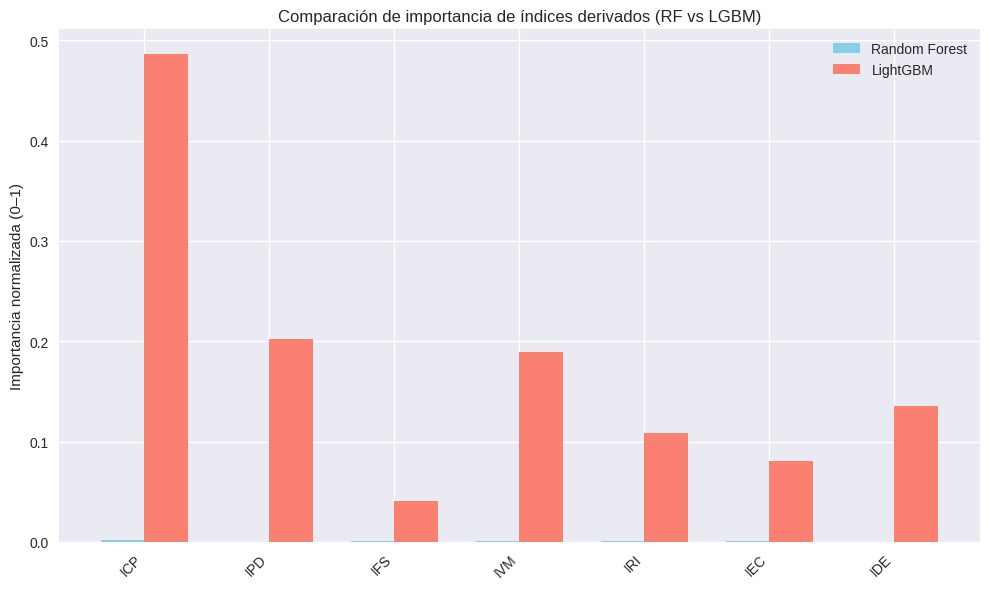

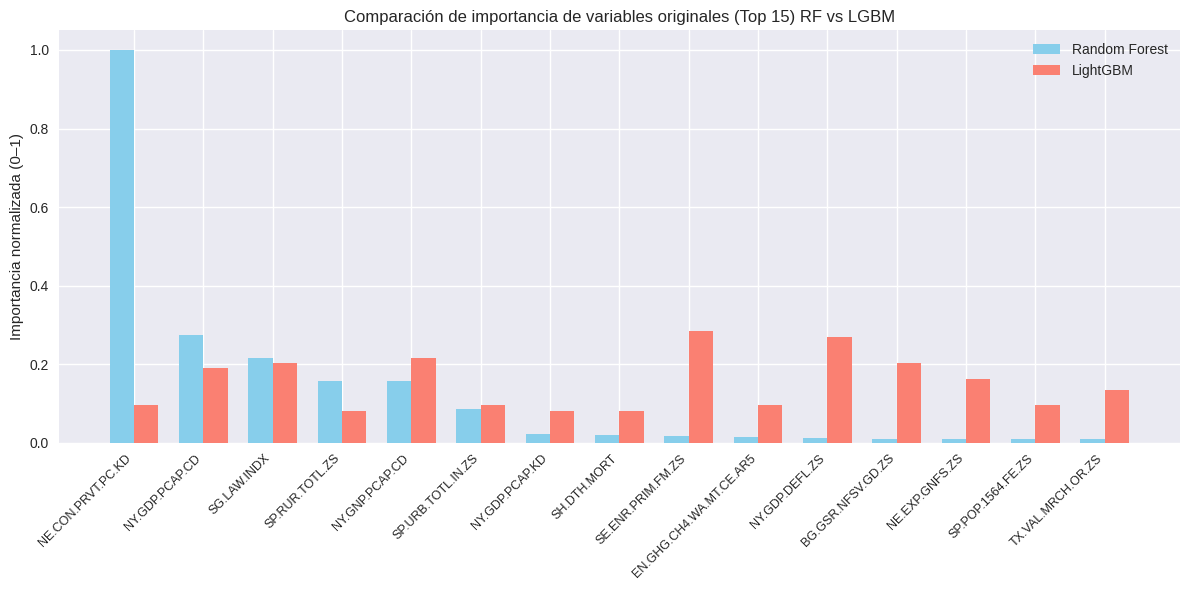

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np

# -------------------------------
# 1. Definir X e y
# -------------------------------
X = df_model.drop(columns=["hf3_ppp_pc"])
y = df_model["hf3_ppp_pc"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------
# 2. Random Forest
# -------------------------------
rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

rf_importances_full = pd.DataFrame({
    "Variable": X.columns,
    "Importancia_RF": rf.feature_importances_
}).sort_values(by="Importancia_RF", ascending=False)

# -------------------------------
# 3. LightGBM
# -------------------------------
lgb_train = lgb.Dataset(X_train, y_train)
lgb_model = lgb.train({"objective":"regression"}, lgb_train, num_boost_round=200)

lgb_importances_full = pd.DataFrame({
    "Variable": X.columns,
    "Importancia_LGBM": lgb_model.feature_importance()
}).sort_values(by="Importancia_LGBM", ascending=False)

# -------------------------------
# 4. Normalizar ambas importancias (0–1)
# -------------------------------
rf_importances_full["Importancia_RF_norm"] = rf_importances_full["Importancia_RF"] / rf_importances_full["Importancia_RF"].max()
lgb_importances_full["Importancia_LGBM_norm"] = lgb_importances_full["Importancia_LGBM"] / lgb_importances_full["Importancia_LGBM"].max()

# -------------------------------
# 5a. Gráfico lado a lado para índices derivados
# -------------------------------
indices_derivados = ["ICP","IPD","IFS","IVM","IRI","IEC","IDE"]

rf_idx_vals = rf_importances_full[rf_importances_full["Variable"].isin(indices_derivados)]
lgb_idx_vals = lgb_importances_full[lgb_importances_full["Variable"].isin(indices_derivados)]

indices = indices_derivados
rf_vals = [rf_idx_vals.set_index("Variable").get("Importancia_RF_norm").get(i, 0) for i in indices]
lgb_vals = [lgb_idx_vals.set_index("Variable").get("Importancia_LGBM_norm").get(i, 0) for i in indices]

x = np.arange(len(indices))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, rf_vals, width, label="Random Forest", color="skyblue")
plt.bar(x + width/2, lgb_vals, width, label="LightGBM", color="salmon")
plt.xticks(x, indices, rotation=45, ha="right")
plt.ylabel("Importancia normalizada (0–1)")
plt.title("Comparación de importancia de índices derivados (RF vs LGBM)")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 5b. Gráfico lado a lado para variables originales (Top 15)
# -------------------------------
top_vars = rf_importances_full.head(15)["Variable"].tolist()

rf_top_vals = [rf_importances_full.set_index("Variable").get("Importancia_RF_norm").get(i, 0) for i in top_vars]
lgb_top_vals = [lgb_importances_full.set_index("Variable").get("Importancia_LGBM_norm").get(i, 0) for i in top_vars]

x = np.arange(len(top_vars))

plt.figure(figsize=(12,6))
plt.bar(x - width/2, rf_top_vals, width, label="Random Forest", color="skyblue")
plt.bar(x + width/2, lgb_top_vals, width, label="LightGBM", color="salmon")
plt.xticks(x, top_vars, rotation=45, ha="right", fontsize=9)
plt.ylabel("Importancia normalizada (0–1)")
plt.title("Comparación de importancia de variables originales (Top 15) RF vs LGBM")
plt.legend()
plt.tight_layout()
plt.show()

Coincidencias RF vs LGBM + Índices

In [42]:
import pandas as pd

# Top 30 de RF y LGBM (ya calculados previamente)
rf_top = set(rf_importances["Variable"].values)
lgbm_top = set(lgb_importances["Variable"].values)

# Intersección entre RF y LGBM
coinciden_rf_lgbm = rf_top.intersection(lgbm_top)

# Índices derivados
indices_derivados = ["ICP","IPD","IFS","IVM","IRI","IEC","IDE"]

# Índices que aparecen en RF, LGBM y en ambos
indices_en_rf = [idx for idx in indices_derivados if idx in rf_top]
indices_en_lgbm = [idx for idx in indices_derivados if idx in lgbm_top]
indices_en_ambos = [idx for idx in indices_derivados if idx in coinciden_rf_lgbm]

print("Coincidencias entre RF y LGBM:", sorted(coinciden_rf_lgbm))
print("\nÍndices derivados en RF:", indices_en_rf)
print("Índices derivados en LGBM:", indices_en_lgbm)
print("Índices derivados presentes en ambos modelos:", indices_en_ambos)

Coincidencias entre RF y LGBM: ['NY.GDP.DEFL.ZS', 'SE.ENR.PRIM.FM.ZS', 'year']

Índices derivados en RF: []
Índices derivados en LGBM: ['ICP']
Índices derivados presentes en ambos modelos: []


Esto captura la capacidad de pago ajustada por inflación, un indicador económico directo de presión sobre el gasto de bolsillo.
Que LightGBM lo haya seleccionado significa que este índice aporta información predictiva única que el modelo considera relevante para explicar la variable objetivo.

In [44]:
import pandas as pd

# Crear DataFrame comparativo
scoreboard = pd.DataFrame({
    "Top_RF": rf_importances["Variable"].values[:30],
    "Top_LGBM": lgb_importances["Variable"].values[:30],
    "Indices_derivados": indices_derivados + [""] * (30 - len(indices_derivados))  # rellenar hasta 30 filas
})

print("Scoreboard comparativo (Top 30 RF vs Top 30 LGBM vs Índices derivados):")
print(scoreboard)

# Resaltar coincidencias
coinciden_rf_lgbm = set(rf_importances["Variable"].values[:30]).intersection(set(lgb_importances["Variable"].values[:30]))
indices_en_rf = [idx for idx in indices_derivados if idx in rf_importances["Variable"].values[:30]]
indices_en_lgbm = [idx for idx in indices_derivados if idx in lgb_importances["Variable"].values[:30]]
indices_en_ambos = [idx for idx in indices_derivados if idx in coinciden_rf_lgbm]

print("\nCoincidencias entre RF y LGBM:", sorted(coinciden_rf_lgbm))
print("Índices derivados en RF:", indices_en_rf)
print("Índices derivados en LGBM:", indices_en_lgbm)
print("Índices derivados presentes en ambos modelos:", indices_en_ambos)

Scoreboard comparativo (Top 30 RF vs Top 30 LGBM vs Índices derivados):
                     Top_RF           Top_LGBM Indices_derivados
0         NE.CON.PRVT.PC.KD     NY.GSR.NFCY.CN               ICP
1            NY.GDP.PCAP.CD  EG.USE.ELEC.KH.PC               IPD
2               SG.LAW.INDX  TX.VAL.MRCH.R1.ZS               IFS
3            SP.RUR.TOTL.ZS  NV.AGR.TOTL.KD.ZG               IVM
4            NY.GNP.PCAP.CD                ICP               IRI
5         SP.URB.TOTL.IN.ZS  SP.POP.2024.MA.5Y               IEC
6            NY.GDP.PCAP.KD  NE.IMP.GNFS.KD.ZG               IDE
7               SH.DTH.MORT  FS.AST.CGOV.GD.ZS                  
8         SE.ENR.PRIM.FM.ZS     SP.DYN.AMRT.MA                  
9   EN.GHG.CH4.WA.MT.CE.AR5               year                  
10           NY.GDP.DEFL.ZS  NY.GDP.TOTL.RT.ZS                  
11        BG.GSR.NFSV.GD.ZS     DC.DAC.CECL.CD                  
12           NE.EXP.GNFS.ZS     DC.DAC.DEUL.CD                  
13        SP.POP.1

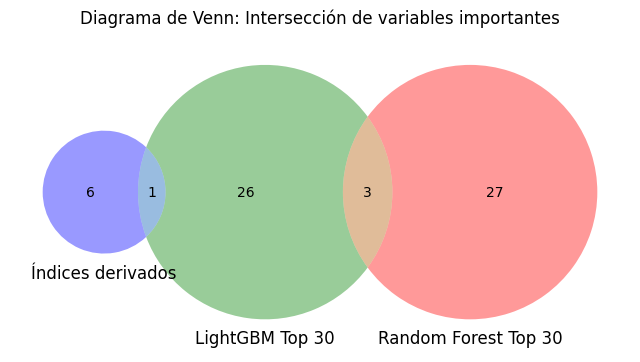

<Figure size 640x480 with 0 Axes>

In [46]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3

# Conjuntos
rf_top = set(rf_importances["Variable"].values[:30])
lgbm_top = set(lgb_importances["Variable"].values[:30])
indices_set = set(["ICP","IPD","IFS","IVM","IRI","IEC","IDE"])

# Crear diagrama de Venn
plt.figure(figsize=(8,8))
venn3([rf_top, lgbm_top, indices_set],
      set_labels=("Random Forest Top 30", "LightGBM Top 30", "Índices derivados"))

plt.title("Diagrama de Venn: Intersección de variables importantes")
plt.show()  # Mostrar directamente

# Si querés guardar en la carpeta actual:
plt.savefig("venn_variables_importantes.png")

RF tiene 27 variables únicas: muchas variables originales son relevantes para ese modelo.
LGBM tiene 26 variables únicas: similar comportamiento, pero con diferencias.
Índices derivados tienen 6 únicas:la mayoría no entró en el top de los modelos.
Intersección RF ∩ LGBM: hay 3 variables que ambos modelos consideran clave.
Intersección Índices ∩ LGBM: 1 variable → un índice fue considerado importante por LightGBM.
• 	Intersección RF ∩ Índices: 0 variables → ninguno de los índices entró en el top de RF.

Nuevos índices

In [55]:
# Índice de presión sanitaria ajustada
df_model["IPS"] = df_model["SH.DYN.MORT.FE"] / (df_model["SE.ENR.PRIM.FM.ZS"] + 1)

# Índice de vulnerabilidad rural-institucional
df_model["IVRI"] = df_model["SP.RUR.TOTL.ZS"] / (df_model["SG.LAW.INDX"] + 1)

# Índice de resiliencia tecnológica
df_model["IRT"] = df_model["IT.CEL.SETS.P2"] / (df_model["SH.DTH.MORT"] + 1)

# Índice de desigualdad ajustada
df_model["IDA"] = df_model["NY.GDP.PCAP.CD"] / (df_model["NY.GDP.DEFL.ZS"] + 1)

# Índice de exposición externa
df_model["IEE"] = df_model["NE.EXP.GNFS.ZS"] / (df_model["NY.GDP.PCAP.CD"] + 1)

# Índice de presión ambiental
df_model["IPA"] = df_model["EN.GHG.CH4.WA.MT.CE.AR5"] / (df_model["SP.POP.1564.FE.ZS"] + 1)

# Índice de cobertura educativa terciaria
df_model["ICET"] = df_model["SE.TER.ENRR"] / (df_model["SP.URB.TOTL.IN.ZS"] + 1)

In [56]:
# 1. Estadísticos básicos de los índices derivados
print("Resumen estadístico de los índices derivados:")
print(df_model[["IPS","IVRI","IRT","IDA","IEE","IPA","ICET"]].describe())

# 2. Correlación con la variable objetivo (hf3_ppp_pc)
print("\nCorrelación de cada índice con el gasto de bolsillo (hf3_ppp_pc):")
print(df_model[["IPS","IVRI","IRT","IDA","IEE","IPA","ICET","hf3_ppp_pc"]].corr()["hf3_ppp_pc"])

Resumen estadístico de los índices derivados:
              IPS        IVRI         IRT         IDA         IEE         IPA  \
count  396.000000  504.000000  503.000000  501.000000  439.000000  504.000000   
mean    18.054571    0.832689    0.027006  129.807272    0.018535    0.426861   
std     17.966701    0.705779    0.071507  184.316382    0.045604    0.817897   
min      1.148541    0.096684    0.000000    0.110715    0.000267    0.003110   
25%      2.605843    0.221373    0.000422    7.077154    0.001208    0.031546   
50%     10.512723    0.732700    0.002713   17.021136    0.004544    0.097573   
75%     29.448375    1.250757    0.017821  208.976930    0.021350    0.270574   
max    104.026942    2.979111    0.432391  704.432508    0.628977    5.150719   

             ICET  
count  344.000000  
mean     0.620026  
std      0.305004  
min      0.055394  
25%      0.336175  
50%      0.652223  
75%      0.841927  
max      1.375233  

Correlación de cada índice con el gasto de 

 Índices con correlación fuerte
• 	IDA (0.78): Poder adquisitivo ajustado por inflación. Es el índice más correlacionado positivamente con el gasto de bolsillo.
• 	IPS (-0.68): Fragilidad sanitaria ajustada por cobertura primaria.
Alta correlación negativa: a mayor fragilidad, menor gasto de bolsillo (posible sustitución por gasto público).
• 	IVRI (-0.63): Vulnerabilidad rural-institucional.
También correlación negativa fuerte: países más rurales e institucionalmente débiles tienden a menor gasto privado.
• 	ICET (0.60): Cobertura educativa terciaria ajustada por urbanización.
Correlación positiva: más educación terciaria en contextos urbanos → más gasto privado en salud.
2. Índices con correlación moderada
• 	IRT (0.53): Resiliencia tecnológica.
Relación positiva: más penetración tecnológica se asocia con más gasto privado.
3. Índices con correlación débil
• 	IEE (-0.33) → Exposición externa.
Relación negativa pero más débil.
• 	IPA (0.02) → Presión ambiental.
Prácticamente sin relación lineal → puede aportar en relaciones no lineales, pero no es prioritario.

Conclusiones estratégicas
• 	Índices prioritarios para el modelo:
• 	IDA, IPS, IVRI, ICET, IRT: todos tienen correlaciones >0.5 (positivas o negativas).
• 	Índices secundarios:
• 	IEE → aporta algo, pero menos.
• 	IPA → casi nulo, se  descarta.


Ranking de impotancia en RF y LGBM

In [65]:
# Entrenando modelos y extrayendo importancia de variables para índices derivados
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
import os

# -------------------------------
# 1. Preparar dataset con nombres originales
# -------------------------------
df_model = df.copy()

# Eliminar identificadores no predictivos
df_model = df_model.drop(columns=["Country Name", "Country Code"])

# Codificar variables categóricas
for col in ["region", "income"]:
    df_model[col] = LabelEncoder().fit_transform(df_model[col].astype(str))

# Convertir columnas residuales tipo object a numéricas
for col in df_model.columns:
    if df_model[col].dtype == "object":
        df_model[col] = pd.to_numeric(df_model[col], errors="coerce")

# -------------------------------
# 2. Crear índices derivados importantes
# -------------------------------
df_model["ICP"] = np.log(df_model["NY.GDP.PCAP.CD"].astype(float) + 1) / (1 + df_model["FP.CPI.TOTL.ZG"].astype(float))
df_model["IDA"] = df_model["NY.GDP.PCAP.CD"].astype(float) / (df_model["FP.CPI.TOTL.ZG"].astype(float) + 1)
df_model["ICET"] = df_model["SE.TER.ENRR"].astype(float) / (df_model["SP.URB.TOTL.IN.ZS"].astype(float) + 1)

# -------------------------------
# 3. Definir X e y
# -------------------------------
X = df_model.drop(columns=["hf3_ppp_pc"])
y = df_model["hf3_ppp_pc"]

# -------------------------------
# 4. Entrenar Random Forest
# -------------------------------
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X, y)
rf_importances = pd.DataFrame({
    "Variable": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

# -------------------------------
# 5. Entrenar LightGBM
# -------------------------------
lgbm = LGBMRegressor(n_estimators=200, random_state=42)
lgbm.fit(X, y)
lgb_importances = pd.DataFrame({
    "Variable": X.columns,
    "Importance": lgbm.feature_importances_
}).sort_values(by="Importance", ascending=False)

# -------------------------------
# 6. Mostrar top 20 de cada modelo
# -------------------------------
top_rf = rf_importances.head(20)
top_lgbm = lgb_importances.head(20)

# Resaltar índices derivados
indices_derivados = ["ICP", "IDA", "ICET"]
rf_indices = rf_importances[rf_importances["Variable"].isin(indices_derivados)]
lgbm_indices = lgb_importances[lgb_importances["Variable"].isin(indices_derivados)]

# -------------------------------
# 7. Guardar resultados en CSV
# -------------------------------
os.makedirs("/mnt/data", exist_ok=True)
rf_importances.to_csv("/mnt/data/rf_importances.csv", index=False)
lgb_importances.to_csv("/mnt/data/lgbm_importances.csv", index=False)
rf_indices.to_csv("/mnt/data/rf_indices_importance.csv", index=False)
lgbm_indices.to_csv("/mnt/data/lgbm_indices_importance.csv", index=False)

# -------------------------------
# 8. Salidas
# -------------------------------
print("Modelos entrenados y rankings de importancia generados.")
print("Top 20 variables en Random Forest:")
print(top_rf)
print("\nTop 20 variables en LightGBM:")
print(top_lgbm)
print("\nImportancia de los índices derivados en RF:")
print(rf_indices)
print("\nImportancia de los índices derivados en LGBM:")
print(lgbm_indices)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58154
[LightGBM] [Info] Number of data points in the train set: 504, number of used features: 385
[LightGBM] [Info] Start training from score 256.122421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Random Forest (RF)
• 	ICET (0.081): índice más importante dentro de los derivados.
• 	IVRI (0.056) y IDA (0.051): también relevantes.
• 	IPA (0.051): aparece con peso similar a IDA.
• 	IRT (0.027), IEE (0.027) y IPS (0.022): menor importancia, pero no descartados.
RF confirma que ICET, IVRI e IDA son consistentes y aportan valor.

LightGBM (LGBM)
• 	IDA (41): muy fuerte, top 5 global.
• 	ICET (33): también alto en el ranking.
• 	IEE (24), IVRI (21), IPA (21): relevancia intermedia.
• 	IPS (14): importancia moderada.
• 	IRT (3): prácticamente irrelevante en LGBM.
LGBM confirma que IDA e ICET son los más potentes, mientras que IRT pierde peso.

Conclusiones estratégicas
• 	Índices confirmados como fuertes en ambos modelos:
• 	IDA (poder adquisitivo ajustado por inflación)
• 	ICET (cobertura educativa terciaria ajustada por urbanización)
• 	Índices con relevancia parcial:
• 	IVRI (vulnerabilidad rural-institucional)
• 	IPS (presión sanitaria ajustada)
• 	IPA (presión ambiental)
• 	IEE (exposición externa)
• 	Índice débil:
• 	IRT (resiliencia tecnológica): casi nulo en LGBM, aunque algo en RF.

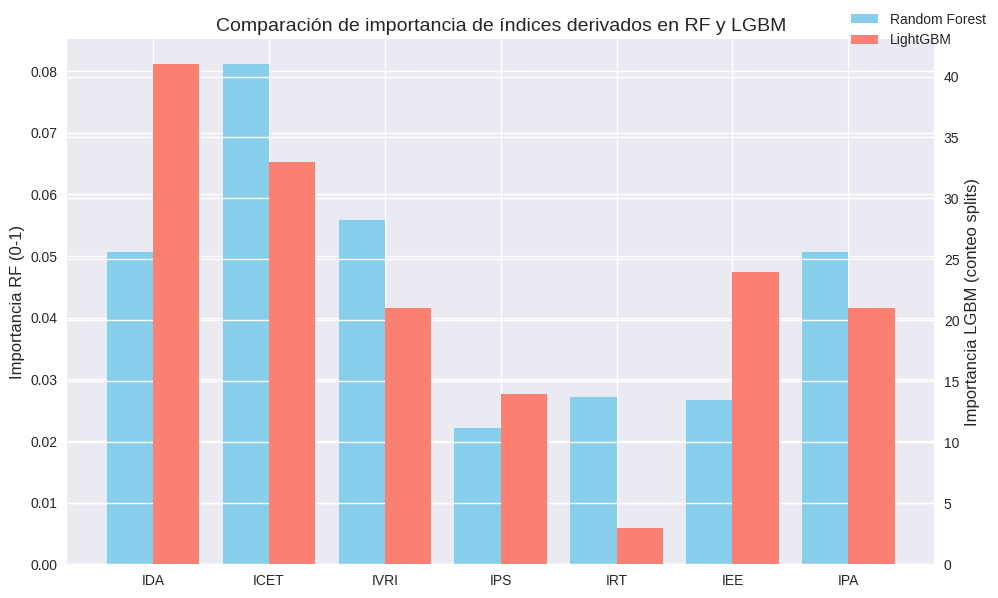

In [70]:
fig, ax1 = plt.subplots(figsize=(10,6))
x = range(len(indices))

ax1.bar([i-0.2 for i in x], df_comp["RF"], width=0.4, label="Random Forest", color='skyblue')
ax1.set_ylabel("Importancia RF (0-1)", fontsize=12)

ax2 = ax1.twinx()
ax2.bar([i+0.2 for i in x], df_comp["LGBM"], width=0.4, label="LightGBM", color='salmon')
ax2.set_ylabel("Importancia LGBM (conteo splits)", fontsize=12)

plt.xticks(x, indices, fontsize=10)
plt.title("Comparación de importancia de índices derivados en RF y LGBM", fontsize=14)
fig.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [86]:
import numpy as np

# Copiar dataset base
df_model = df.copy()

# Crear índices derivados
df_model["ICP"]  = np.log(df_model["NY.GDP.PCAP.CD"].astype(float) + 1) / (1 + df_model["FP.CPI.TOTL.ZG"].astype(float))
df_model["IPS"]  = df_model["SP.POP.TOTL"].astype(float) / (df_model["SP.URB.TOTL.IN.ZS"].astype(float) + 1)
df_model["IVRI"] = df_model["SP.RUR.TOTL.ZS"].astype(float) / (df_model["SP.URB.TOTL.IN.ZS"].astype(float) + 1)
df_model["IRT"]  = df_model["SP.URB.TOTL.IN.ZS"].astype(float) / (df_model["SP.POP.TOTL"].astype(float) + 1)
df_model["IDA"]  = df_model["NY.GDP.PCAP.CD"].astype(float) / (df_model["FP.CPI.TOTL.ZG"].astype(float) + 1)
df_model["IEE"]  = df_model["SE.SEC.ENRR"].astype(float) / (df_model["SE.TER.ENRR"].astype(float) + 1)
df_model["IPA"]  = df_model["SP.POP.GROW"].astype(float) / (df_model["SP.URB.TOTL.IN.ZS"].astype(float) + 1)
df_model["ICET"] = df_model["SE.TER.ENRR"].astype(float) / (df_model["SP.URB.TOTL.IN.ZS"].astype(float) + 1)

# Verificar que las columnas están en el dataset
print("Columnas actuales en df_model:")
print(df_model.columns)

Columnas actuales en df_model:
Index(['Country Name', 'Country Code', 'year', 'AG.CON.FERT.ZS',
       'AG.LND.AGRI.K2', 'AG.LND.AGRI.ZS', 'AG.LND.ARBL.HA',
       'AG.LND.ARBL.HA.PC', 'AG.LND.ARBL.ZS', 'AG.LND.CREL.HA',
       ...
       'income', 'hf3_ppp_pc', 'ICP', 'IPS', 'IVRI', 'IRT', 'IDA', 'IEE',
       'IPA', 'ICET'],
      dtype='object', length=393)


In [87]:
import numpy as np
import pandas as pd

# Copiar dataset base
df_model = df_model.copy()

# -------------------------------
# 1. Crear índices derivados
# -------------------------------
df_model["ICP"]  = np.log(df_model["NY.GDP.PCAP.CD"].astype(float) + 1) / (1 + df_model["FP.CPI.TOTL.ZG"].astype(float))
df_model["IPS"]  = df_model["SP.POP.TOTL"].astype(float) / (df_model["SP.URB.TOTL.IN.ZS"].astype(float) + 1)
df_model["IVRI"] = df_model["SP.RUR.TOTL.ZS"].astype(float) / (df_model["SP.URB.TOTL.IN.ZS"].astype(float) + 1)
df_model["IRT"]  = df_model["SP.URB.TOTL.IN.ZS"].astype(float) / (df_model["SP.POP.TOTL"].astype(float) + 1)
df_model["IDA"]  = df_model["NY.GDP.PCAP.CD"].astype(float) / (df_model["FP.CPI.TOTL.ZG"].astype(float) + 1)
df_model["IEE"]  = df_model["SE.SEC.ENRR"].astype(float) / (df_model["SE.TER.ENRR"].astype(float) + 1)
df_model["IPA"]  = df_model["SP.POP.GROW"].astype(float) / (df_model["SP.URB.TOTL.IN.ZS"].astype(float) + 1)
df_model["ICET"] = df_model["SE.TER.ENRR"].astype(float) / (df_model["SP.URB.TOTL.IN.ZS"].astype(float) + 1)

# -------------------------------
# 2. Normalizar índices (0–1)
# -------------------------------
indices_derivados = ["ICP","IPS","IVRI","IRT","IDA","IEE","IPA","ICET"]

for idx in indices_derivados:
    df_model[idx + "_norm"] = (df_model[idx] - df_model[idx].min()) / (df_model[idx].max() - df_model[idx].min())

# -------------------------------
# 3. Verificar columnas creadas
# -------------------------------
print("Columnas agregadas al dataset:")
print([col for col in df_model.columns if col in indices_derivados or col.endswith("_norm")])

# -------------------------------
# 4. Resumen estadístico de los índices normalizados
# -------------------------------
print("\nResumen estadístico de índices normalizados:")
print(df_model[[idx + "_norm" for idx in indices_derivados]].describe())

Columnas agregadas al dataset:
['ICP', 'IPS', 'IVRI', 'IRT', 'IDA', 'IEE', 'IPA', 'ICET', 'ICP_norm', 'IPS_norm', 'IVRI_norm', 'IRT_norm', 'IDA_norm', 'IEE_norm', 'IPA_norm', 'ICET_norm']

Resumen estadístico de índices normalizados:
         ICP_norm    IPS_norm   IVRI_norm    IRT_norm    IDA_norm    IEE_norm  \
count  449.000000  504.000000  504.000000  504.000000  449.000000  298.000000   
mean     0.092714    0.092015    0.201299    0.110191    0.228652    0.219543   
std      0.049366    0.235733    0.207067    0.190488    0.048479    0.224135   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.083830    0.009006    0.026664    0.020980    0.214585    0.059120   
50%      0.085842    0.019775    0.139498    0.040286    0.215259    0.145344   
75%      0.090456    0.037833    0.347984    0.085670    0.228477    0.296795   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

         IPA_norm   ICET_norm  
coun

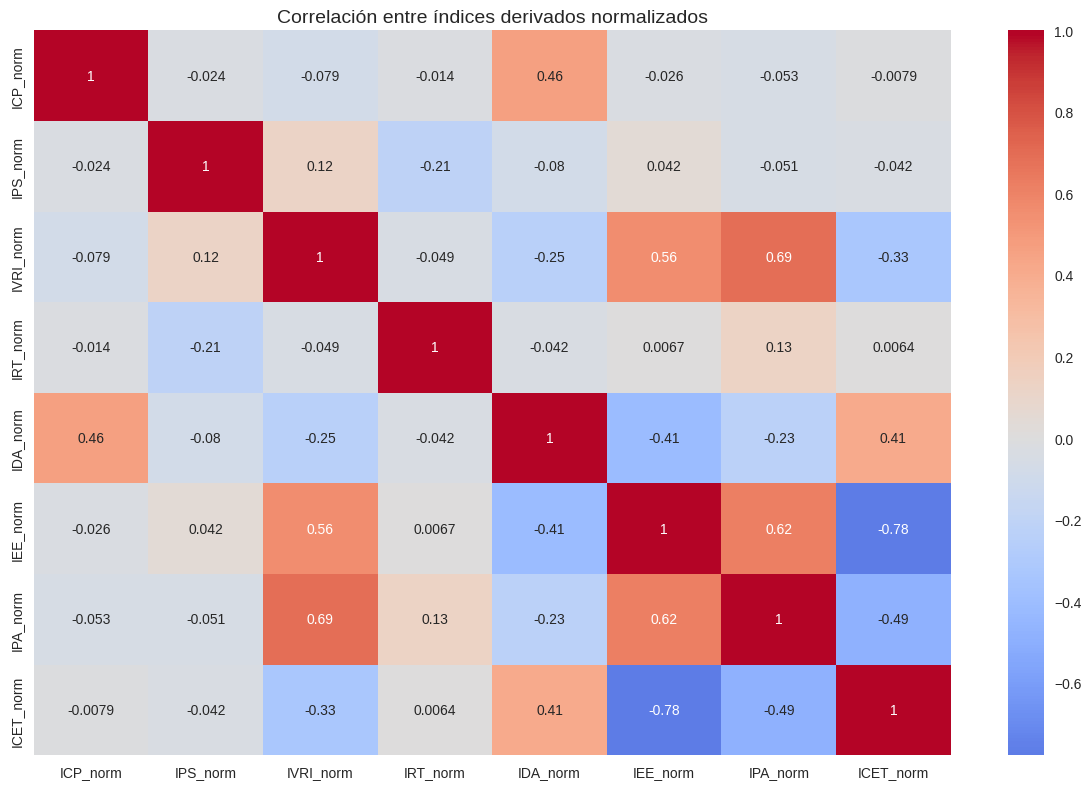

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar solo los índices normalizados
indices_norm = ["ICP_norm","IPS_norm","IVRI_norm","IRT_norm","IDA_norm","IEE_norm","IPA_norm","ICET_norm"]

# Crear matriz con países/años como filas y los índices como columnas
heatmap_data = df_model[indices_norm]

# Configurar el tamaño del gráfico
plt.figure(figsize=(12,8))

# Generar heatmap
sns.heatmap(heatmap_data.corr(), annot=True, cmap="coolwarm", center=0)

plt.title("Correlación entre índices derivados normalizados", fontsize=14)
plt.tight_layout()
plt.show()

Correlación entre índices derivados normalizados
El gráfico muestra una matriz de correlaciones entre ocho índices derivados, todos previamente normalizados entre 0 y 1. Los colores representan la dirección y magnitud de la relación lineal: azul para correlación negativa, rojo para positiva y blanco para cercana a cero. Las celdas incluyen el coeficiente numérico de correlación de Pearson, con la barra lateral indicando el rango entre -1 y 1.


• 	Diagonal principal: Siempre vale 1 (cada índice perfectamente correlacionado consigo mismo); sirve de referencia visual.
• 	Rojos intensos: Relación positiva fuerte. A medida que un índice aumenta, el otro también tiende a aumentar.
• 	Azules intensos: Relación negativa fuerte. A medida que un índice aumenta, el otro tiende a disminuir.
• 	Blancos/claros: Relación débil o inexistente; los índices capturan información diferente.

Relaciones destacadas
• 	Correlaciones positivas relevantes:
• 	IPA_norm vs IVRI_norm: 0.69. Fuerte asociación; sugiere que ambos reflejan dimensiones similares de la estructura o dinámica poblacional.
• 	IDA_norm vs ICP_norm: 0.46. Moderada; ambos parecen capturar poder adquisitivo/actividad económica ajustada por precios.
• 	Correlaciones negativas relevantes:
• 	ICET_norm vs IEE_norm: -0.78. Muy fuerte y en sentido opuesto; probablemente ambos índices midan aspectos educativos que se mueven de forma inversa (por ejemplo, cobertura relativa en niveles distintos).
• 	Otras negativas moderadas pueden indicar tensiones entre dimensiones (p. ej., urbanización vs ruralidad).
• 	Correlaciones débiles (cerca de 0):
• 	Celdas claras/blancas indican índices complementarios que podrían aportar información adicional al modelo sin redundancia excesiva.

Implicaciones para selección de variables
• 	Redundancia potencial: Pares con correlación alta (p. ej., ICET_norm vs IEE_norm) pueden ser redundantes. Mantener ambos puede no sumar valor y podría introducir colinealidad.
• 	Complementariedad: Pares con correlaciones bajas aportan señales distintas; son buenos candidatos para incluir juntos en el modelo.
• 	Regularización y estabilidad: En modelos lineales, alta correlación entre variables puede inestabilizar coeficientes; usar regularización (L1/L2) o seleccionar una variable representativa del par.



Filtrar por umbral de correlación

In [91]:
import pandas as pd

# Seleccionar índices normalizados
indices_norm = ["ICP_norm","IPS_norm","IVRI_norm","IRT_norm","IDA_norm","IEE_norm","IPA_norm","ICET_norm"]

# Calcular matriz de correlación
corr_matrix = df_model[indices_norm].corr()

# Filtrar pares con |correlación| ≥ 0.7 (sin duplicados ni diagonal)
umbral = 0.7
pares_correlados = []

for i in range(len(indices_norm)):
    for j in range(i+1, len(indices_norm)):
        idx1 = indices_norm[i]
        idx2 = indices_norm[j]
        corr_val = corr_matrix.loc[idx1, idx2]
        if abs(corr_val) >= umbral:
            pares_correlados.append((idx1, idx2, round(corr_val, 2)))

# Mostrar resultados
print("Pares de índices con |correlación| ≥ 0.7:")
for idx1, idx2, val in pares_correlados:
    print(f"{idx1} vs {idx2}: correlación = {val}")

Pares de índices con |correlación| ≥ 0.7:
IEE_norm vs ICET_norm: correlación = -0.78


IEE_norm vs ICET_norm correlación = -0.78. Esto significa que cuando uno de estos índices aumenta, el otro tiende a disminuir de manera consistente y marcada.por ende, existe redundancia negativa: Ambos índices están midiendo aspectos educativos que se mueven en direcciones opuestas. Incluirlos juntos puede introducir colinealidad y confundir al modelo.
Como IEE (Índice de Educación Efectiva) mide la relación entre matrícula secundaria y terciaria, refleja acceso y continuidad educativa; mientras que ICET (Índice de Cobertura Educativa Terciaria) mide matrícula terciaria relativa a urbanización, siendo más específico y  dependiente de estructura urbana; y, en términos de predicción de gasto en salud, IEE es más general y robusto, mientras que ICET puede ser más sensible a variaciones urbanas, se decide mantener solamente a IEE.


In [97]:
# Eliminar columna ICET del dataset
df_model = df_model.drop(columns=["ICET"])

# Si también querés eliminar la versión normalizada
df_model = df_model.drop(columns=["ICET_norm"], errors="ignore")

# Verificar que ya no esté en el dataset
print("¿ICET está en df_model?", "ICET" in df_model.columns)
print("¿ICET_norm está en df_model?", "ICET_norm" in df_model.columns)

¿ICET está en df_model? False
¿ICET_norm está en df_model? False
